In [32]:
!pip install umap-learn
!pip install keras_tuner

import os
import re
import nltk
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import umap.umap_ as umap
import keras_tuner
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec, FastText
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, GRU, Conv1D, MaxPooling1D, Bidirectional, LeakyReLU, Multiply, Flatten, Activation, RepeatVector, Permute, Reshape, GlobalMaxPooling1D, Concatenate, BatchNormalization, Layer
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.optimizers import Adam
from keras_tuner import BayesianOptimization
from keras_tuner.engine.hypermodel import HyperModel
from keras_tuner.tuners import Hyperband
from tensorflow.keras.optimizers.schedules import ExponentialDecay


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [34]:
# Loading the data and anonymising by dropping the 'id' column and dropping columns oher than 'text' and 'HS', as they are unnecessary

train_df = pd.read_csv('train_en.tsv', sep='\t', usecols=[1, 2])
val_df = pd.read_csv('dev_en.tsv', sep='\t', usecols=[1, 2])
test_df = pd.read_csv('test_en.tsv', sep='\t', usecols=[1, 2], names=['text', 'HS'], header=None)


In [35]:
# 1. Exploration

In [36]:
#test for missing data

# Check for missing data in train_df
missing_train_data = train_df.isnull().sum()
print("Missing data in train_df:")
print(missing_train_data)

# Check for missing data in val_df
missing_val_data = val_df.isnull().sum()
print("\nMissing data in val_df:")
print(missing_val_data)

# Check for missing data in test_df
missing_test_data = test_df.isnull().sum()
print("\nMissing data in test_df:")
print(missing_test_data)


Missing data in train_df:
text    0
HS      0
dtype: int64

Missing data in val_df:
text    0
HS      0
dtype: int64

Missing data in test_df:
text    0
HS      0
dtype: int64


In [37]:
#Find out train-validation-test split
total_samples = len(train_df) + len(val_df) + len(test_df)

train_percentage = len(train_df) / total_samples * 100
val_percentage = len(val_df) / total_samples * 100
test_percentage = len(test_df) / total_samples * 100

print(f"Training set: {train_percentage:.2f}%")
print(f"Validation set: {val_percentage:.2f}%")
print(f"Test set: {test_percentage:.2f}%")


Training set: 69.39%
Validation set: 7.71%
Test set: 22.90%


          Set  Class Distribution  Average Length  Max Length  Min Length
0    Training  {0: 0.58, 1: 0.42}           11.89          45           0
1  Validation  {0: 0.57, 1: 0.43}           13.84          38           0
2        Test  {0: 0.58, 1: 0.42}           12.33          38           1
Hate speech most common words: [('bitch', 925), ('woman', 609), ('u', 444), ('illegal', 425), ('buildthatwall', 344), ('like', 338), ('refugee', 328), ('immigration', 318), ('whore', 293), ('get', 291)]
Non-hate speech most common words: [('refugee', 878), ('immigrant', 836), ('woman', 722), ('migrant', 461), ('men', 424), ('u', 423), ('like', 360), ('immigration', 356), ('people', 287), ('rape', 280)]
Hate speech most common bigrams: [(('illegal', 'alien'), 130), (('illegal', 'immigrant'), 107), (('trump', 'maga'), 72), (('go', 'home'), 59), (('hysterical', 'woman'), 58), (('free', 'speech'), 56), (('speech', 'time'), 55), (('illegal', 'immigration'), 51), (('shut', 'fuck'), 50), (('illegal', '

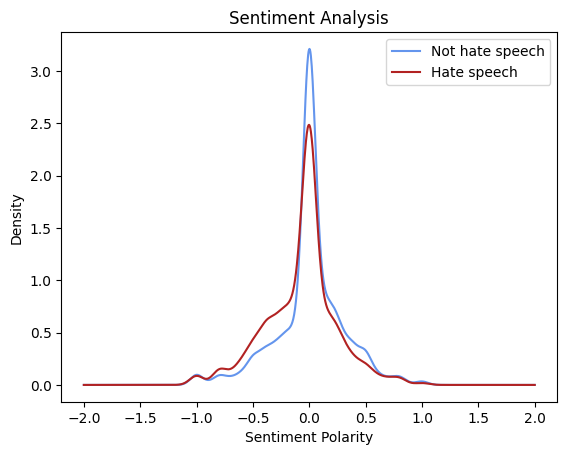

In [38]:
#Initial preprocessing

# Preprocess text
stop_words = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Define regular expression pattern to match "US" and "US." in uppercase letters
    pattern = re.compile(r'\b[U][S]\.?\\b')
    
    # Replace "US" and "US." with "USA"
    text = re.sub(pattern, "USA", text)
    
    # Lowercase the text
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove mentions
    text = re.sub(r'\@\w+|\#', '', text)

    # Remove special characters
    text = re.sub(r'\W', ' ', text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and lemmatize the words
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words]

    # Join the tokens back into a single string
    text = ' '.join(lemmatized_tokens)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    
    return text, lemmatized_tokens

train_df[['text','tokens']] = train_df['text'].apply(lambda x: pd.Series(preprocess_text(x)))
val_df[['text','tokens']] = val_df['text'].apply(lambda x: pd.Series(preprocess_text(x)))
test_df[['text','tokens']] = test_df['text'].apply(lambda x: pd.Series(preprocess_text(x)))

#Check class distribution

def basic_stats(df, column):
    avg_len = df[column].apply(lambda x: len(x.split())).mean()
    max_len = df[column].apply(lambda x: len(x.split())).max()
    min_len = df[column].apply(lambda x: len(x.split())).min()
    return avg_len, max_len, min_len

def check_distribution(train_df, val_df, test_df, text_col, label_col):
    train_class_dist = train_df[label_col].value_counts(normalize=True).round(2)
    val_class_dist = val_df[label_col].value_counts(normalize=True).round(2)
    test_class_dist = test_df[label_col].value_counts(normalize=True).round(2)

    train_avg_len, train_max_len, train_min_len = basic_stats(train_df, text_col)
    val_avg_len, val_max_len, val_min_len = basic_stats(val_df, text_col)
    test_avg_len, test_max_len, test_min_len = basic_stats(test_df, text_col)

    stats_df = pd.DataFrame({
        'Set': ['Training', 'Validation', 'Test'],
        'Class Distribution': [train_class_dist.to_dict(), val_class_dist.to_dict(), test_class_dist.to_dict()],
        'Average Length': [train_avg_len, val_avg_len, test_avg_len],
        'Max Length': [train_max_len, val_max_len, test_max_len],
        'Min Length': [train_min_len, val_min_len, test_min_len],
    })

    # Round the relevant columns to 2 significant figures
    stats_df['Average Length'] = stats_df['Average Length'].round(2)
    stats_df['Max Length'] = stats_df['Max Length'].round(2)
    stats_df['Min Length'] = stats_df['Min Length'].round(2)

    return stats_df

stats_df = check_distribution(train_df, val_df, test_df, 'text', 'HS')
print(stats_df)



# 2. Word Frequency Analysis
def word_frequency_analysis(tokens_list):
    all_tokens = [token for tokens in tokens_list for token in tokens]
    return Counter(all_tokens).most_common(10)

hate_speech_tokens = train_df[train_df['HS'] == 1]['tokens']
non_hate_speech_tokens = train_df[train_df['HS'] == 0]['tokens']

print("Hate speech most common words:", word_frequency_analysis(hate_speech_tokens))
print("Non-hate speech most common words:", word_frequency_analysis(non_hate_speech_tokens))

# 3. N-gram Analysis
def ngram_analysis(tokens_list, n=2):
    all_ngrams = [ngram for tokens in tokens_list for ngram in nltk.ngrams(tokens, n)]
    return Counter(all_ngrams).most_common(10)

print("Hate speech most common bigrams:", ngram_analysis(hate_speech_tokens, 2))
print("Non-hate speech most common bigrams:", ngram_analysis(non_hate_speech_tokens, 2))

# 4. Sentiment Analysis
train_df['sentiment'] = train_df['text'].apply(lambda text: TextBlob(text).sentiment.polarity)

fig, ax = plt.subplots()
train_df[train_df['HS'] == 0]['sentiment'].plot(kind='kde', legend=True, ax=ax, color='cornflowerblue')
train_df[train_df['HS'] == 1]['sentiment'].plot(kind='kde', legend=True, ax=ax, color='firebrick')

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')

handles, labels = ax.get_legend_handles_labels()
labels = ['Not hate speech', 'Hate speech']
ax.legend(handles, labels)

plt.show()


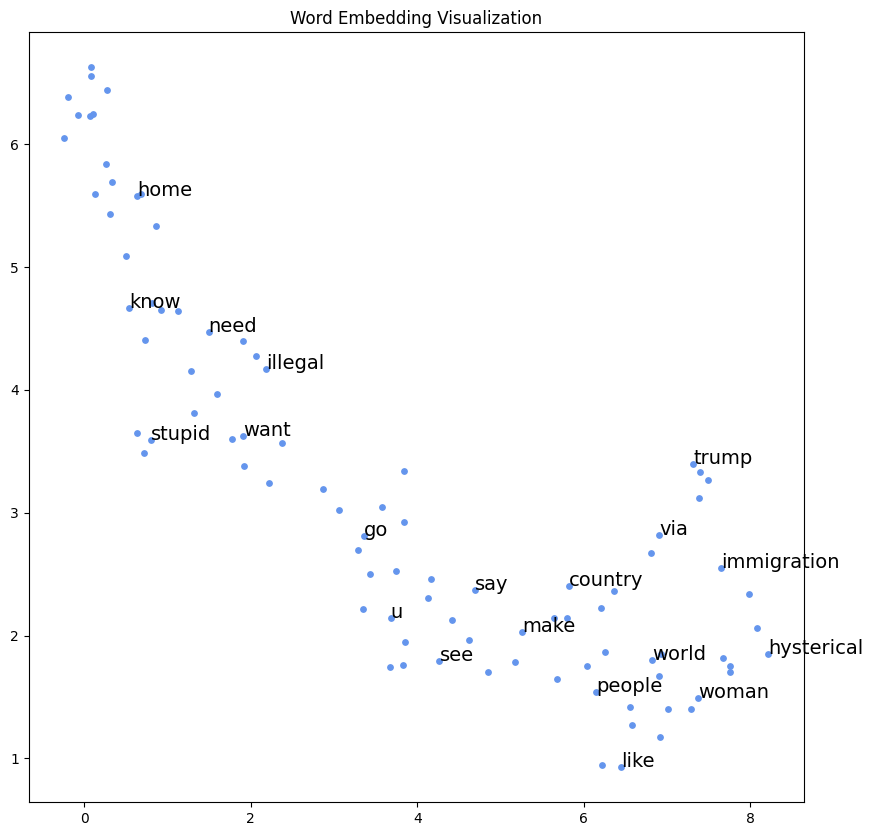

In [69]:
import numpy as np

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def visualize_embeddings(tokens_list, method='word2vec', n_words=300, n_displayed_words=50, min_distance=0.1, offensive_words=None):
    # Train word embeddings
    if method == 'word2vec':
        model = Word2Vec(tokens_list, vector_size=100, window=5, min_count=3, workers=4)
        word_vectors = model.wv

    # Select the n_words most frequent words
    vocab = sorted(word_vectors.key_to_index.keys(), key=lambda x: word_vectors.get_vecattr(x, 'count'), reverse=True)[:n_words]
    
    # Filter out offensive words if provided
    if offensive_words is not None:
        vocab = [word for word in vocab if word.lower() not in offensive_words]
    
    vectors = [word_vectors[word] for word in vocab]
    
    # Perform dimensionality reduction using UMAP
    reducer = umap.UMAP(random_state=42)
    embeddings_2d = reducer.fit_transform(vectors)
    
    # Filter words based on a minimum distance threshold
    displayed_words = []
    for i, word in enumerate(vocab):
        too_close = False
        for displayed_word in displayed_words:
            if euclidean_distance(embeddings_2d[i], embeddings_2d[displayed_word]) < min_distance:
                too_close = True
                break
        if not too_close and len(displayed_words) < n_displayed_words:
            displayed_words.append(i)
    
    # Visualize embeddings
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=15, color = 'cornflowerblue')

    for i in displayed_words:  # Display the selected words
        plt.annotate(vocab[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=14)
    
    plt.title('Word Embedding Visualization')
    plt.show()

# List of offensive words to filter out
offensive_words_list = ['cunt', 'rape', 'bitch', 'fuck', 'hoe', 'whore', 'fucking', 'dick']

# Visualize the embeddings
visualize_embeddings(train_df['tokens'], method='word2vec', n_words=100, n_displayed_words=20, min_distance=0.6, offensive_words=offensive_words_list)


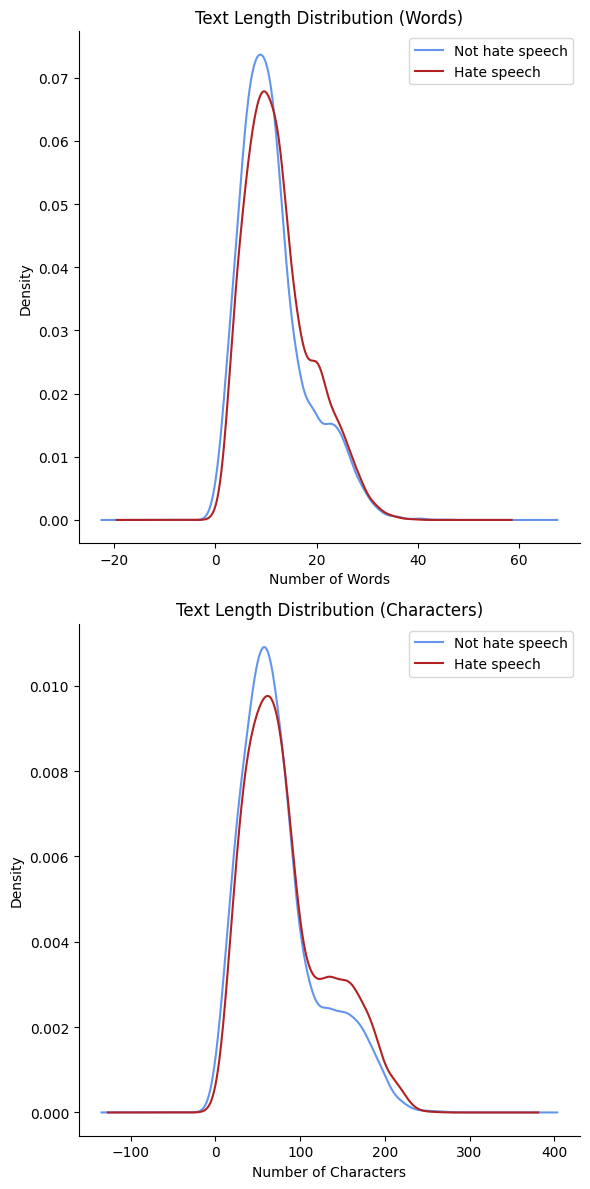

In [40]:
# 6. Text Length Distribution
train_df['num_words'] = train_df['tokens'].apply(len)
train_df['num_chars'] = train_df['text'].apply(len)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

train_df[train_df['HS'] == 0]['num_words'].plot(kind='kde', legend=True, ax=ax1, color='cornflowerblue', label='Not hate speech')
train_df[train_df['HS'] == 1]['num_words'].plot(kind='kde', legend=True, ax=ax1, color='firebrick', label='Hate speech')
ax1.set_title('Text Length Distribution (Words)')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Density')

train_df[train_df['HS'] == 0]['num_chars'].plot(kind='kde', legend=True, ax=ax2, color='cornflowerblue', label='Not hate speech')
train_df[train_df['HS'] == 1]['num_chars'].plot(kind='kde', legend=True, ax=ax2, color='firebrick', label='Hate speech')
ax2.set_title('Text Length Distribution (Characters)')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Density')

# Remove the box around the plots
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Only display the coordinate axes
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

plt.tight_layout()
plt.show()


In [41]:
#Calculating average length of tweets and frequency of features(unique words)

texts = train_df['text'].tolist()

# Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Calculate the average length of tweets
tweet_lengths = [len(seq) for seq in sequences]
avg_tweet_length = int(round(sum(tweet_lengths) / len(tweet_lengths)))

# Analyze the frequency distribution of words
word_counts = Counter(tokenizer.word_index)
total_words = len(word_counts)
total_word_occurrences = sum(word_counts.values())

# Calculate the cumulative word frequency
cumulative_word_frequency = 0
max_features = 0

for word, count in word_counts.most_common():
    cumulative_word_frequency += count
    max_features += 1
    
    # Stop when the cumulative word frequency covers 90% of the total word occurrences
    if cumulative_word_frequency / total_word_occurrences >= 0.9:
        break

print("Average tweet length:", avg_tweet_length)
print("Max features:", max_features)


Average tweet length: 12
Max features: 10352


In [42]:
# 2. Further preprocessing and embedding

In [43]:
#Load Universal Sentence Encoder

#embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
USE_model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return USE_model(input)

# Get sentence embeddings
train_embeddings = embed(train_df['text']).numpy()
val_embeddings = embed(val_df['text']).numpy()
test_embeddings = embed(test_df['text']).numpy()

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [44]:
#Creating labels
y_train = train_df['HS'].values

y_val = val_df['HS'].values

y_test = test_df['HS'].values


In [45]:
#Feature extraction

scaler = MinMaxScaler()

#Calculate tweet length and sentiment polarity and add to df

def normalize_num_words(df):
    df['num_words'] = df['tokens'].apply(len)
    max_num_words = df['num_words'].max()
    df['normalized_num_words'] = df['num_words'] / max_num_words
    return df

def add_sentiment_polarity(df):
    df['sentiment_polarity'] = df['text'].apply(lambda text: TextBlob(text).sentiment.polarity)
    return df

def extract_features(df):
    df = normalize_num_words(df)
    df = add_sentiment_polarity(df)
    return df

train_df = extract_features(train_df)
val_df = extract_features(val_df)
test_df = extract_features(test_df)

#Calculate Hateful words and n-grams and add if present or absent to df

# Calculate the most common hateful words and bigrams
hate_speech_tokens = train_df[train_df['HS'] == 1]['tokens']
top_hateful_words = word_frequency_analysis(hate_speech_tokens)
top_hateful_bigrams = ngram_analysis(hate_speech_tokens, n=2)

# Calculate the most common words for non-hate speech tokens
non_hate_speech_tokens = train_df[train_df['HS'] == 0]['tokens']
top_non_hateful_words = word_frequency_analysis(non_hate_speech_tokens)

# Find the common words
common_words = set(word for word, _ in top_hateful_words) & set(word for word, _ in top_non_hateful_words)

# Filter out the common words
top_hateful_words = [(word, count) for word, count in top_hateful_words if word not in common_words]

# The rest of your code remains the same


#Create new features for the presence of top 10 hateful words and n-grams in tweet
def create_hate_features(df, top_hateful_words, top_hateful_bigrams):
    # Binary feature for the presence of any of the top 10 hateful words
    df['contains_hateful_word'] = df['tokens'].apply(lambda tokens: any(word in tokens for word, _ in top_hateful_words))

    # Binary feature for the presence of any of the top 10 hateful bigrams
    df['contains_hateful_bigram'] = df['tokens'].apply(
        lambda tokens: any(
            bigram in nltk.ngrams(tokens, 2) for bigram, _ in top_hateful_bigrams
        )
    )

    return df

#Populate top hateful words and n-gram features and scale number of words in tweet
def prepare_feature_matrix(df, top_hateful_words, top_hateful_bigrams):
    df = create_hate_features(df, top_hateful_words, top_hateful_bigrams)
    X = df[['normalized_num_words', 'sentiment_polarity', 'contains_hateful_word', 'contains_hateful_bigram']].values
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    return X

# Prepare the additional feature matrices for train, val, and test data
X_train_add_features = prepare_feature_matrix(train_df, top_hateful_words, top_hateful_bigrams)

X_val_add_features = prepare_feature_matrix(val_df, top_hateful_words, top_hateful_bigrams)

X_test_add_features = prepare_feature_matrix(test_df, top_hateful_words, top_hateful_bigrams)



In [46]:
# 3. Bulding the models

In [47]:
#Define custom macro f1 score for early stopping and checkpoint

class MacroF1EarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, patience=0, verbose=0):
        super(MacroF1EarlyStopping, self).__init__()
        self.patience = patience
        self.verbose = verbose
        self.best_score = -np.inf
        self.wait = 0
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs=None):
        y_pred_val = self.model.predict(self.X_val)
        y_pred_val = (y_pred_val > 0.5).astype(int)
        score = f1_score(self.y_val, y_pred_val, average='macro')
        
        # Store the computed macro average F1 score in the logs dictionary
        logs['val_macro_average_f1'] = score

        if score > self.best_score:
            self.wait = 0
            self.best_score = score
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.verbose:
                    print(f"Epoch {epoch}: early stopping due to no improvement in macro F1 score")
                self.model.stop_training = True


class MacroF1ModelCheckpoint(Callback):
    def __init__(self, filepath, validation_data, verbose=0):
        super(MacroF1ModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.best_score = 0
        self.verbose = verbose
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred > 0.5).astype(int)
        y_true = self.validation_data[1]
        score = f1_score(y_true, y_pred, average='macro')
        if score > self.best_score:
            self.best_score = score
            if self.verbose:
                print(f"Epoch {epoch}: macro F1 score improved from {self.best_score} to {score}, saving model to {self.filepath}")
            self.model.save(self.filepath, overwrite=True)
        else:
            if self.verbose:
                print(f"Epoch {epoch}: macro F1 score did not improve from {self.best_score}")



In [48]:
#Define model trainer 

def trainer(model, X, y, validation_data, name, epochs = 20, batch_size = 256):
  # Set early stopping and model checkpoint callbacks
  callbacks = [
      MacroF1EarlyStopping(validation_data = validation_data, patience=5, verbose=1),
      MacroF1ModelCheckpoint(name, validation_data, verbose=1)]

  #Train the model
  history = model.fit(
      X,
      y,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=validation_data,
      callbacks=callbacks)
  
  return history


In [49]:
#Define custom Multiple choice CNN layer

class MultipleChoiceCNN(Layer):
    def __init__(self, num_filters, kernel_sizes, **kwargs):
        super(MultipleChoiceCNN, self).__init__(**kwargs)
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes

    def build(self, input_shape):
        self.conv_layers = [keras.layers.Conv1D(filters=self.num_filters,
                                                   kernel_size=k,
                                                   activation='relu')
                            for k in self.kernel_sizes]
        self.pooling_layers = [keras.layers.GlobalMaxPooling1D() for _ in self.kernel_sizes]

    def call(self, inputs):
        conv_outputs = [pool(conv(inputs)) for conv, pool in zip(self.conv_layers, self.pooling_layers)]
        return tf.concat(conv_outputs, axis=-1)

In [50]:
# Define Attention mechanism

def attention(inputs):
    q = Dense(1, activation='tanh')(inputs)
    q = Flatten()(q)
    a = Activation('softmax')(q)
    a = RepeatVector(64 * 2)(a)
    a = Permute([2, 1])(a)
    return Multiply()([inputs, a])

In [51]:
#Model0, Baseline: GRU

In [52]:
# Define model architecture
model0 = tf.keras.Sequential([
    # Add Embedding layer with pre-trained embeddings
    tf.keras.layers.Input(shape=(train_embeddings.shape[1],), name='embeddings_input'),
    tf.keras.layers.Reshape((-1, 1)),

    
    # GRU layer
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dropout(0.3),
    
    # Dense layers
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model0.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

model0.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 512, 1)            0         
                                                                 
 gru_2 (GRU)                 (None, 64)                12864     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,977
Trainable params: 14,977
Non-trai

In [68]:
trainer(model0, train_embeddings, y_train, [val_embeddings, y_val], 'model.h5')


Epoch 1/20
32/32 [==============================] - 2s 67ms/step
Epoch 0: macro F1 score improved from 0.3642720915448188 to 0.3642720915448188, saving model to model.h5
36/36 [==============================] - 41s 1s/step - loss: 0.6795 - accuracy: 0.5797 - val_loss: 0.6822 - val_accuracy: 0.5730 - val_macro_average_f1: 0.3643
Epoch 2/20
32/32 [==============================] - 2s 57ms/step
Epoch 1: macro F1 score did not improve from 0.3642720915448188
36/36 [==============================] - 38s 1s/step - loss: 0.6792 - accuracy: 0.5797 - val_loss: 0.6804 - val_accuracy: 0.5730 - val_macro_average_f1: 0.3643
Epoch 3/20
32/32 [==============================] - 2s 60ms/step
Epoch 2: macro F1 score improved from 0.4412220065854031 to 0.4412220065854031, saving model to model.h5
36/36 [==============================] - 39s 1s/step - loss: 0.6769 - accuracy: 0.5802 - val_loss: 0.6661 - val_accuracy: 0.5900 - val_macro_average_f1: 0.4412
Epoch 4/20
32/32 [==============================] -

In [54]:
#Model 1: Universal Sentence Encoder-based Multiple-Choice Attentive GRU Integrated CNN (USE-MAGIC)

In [55]:
# Model architecture

# Sentence embeddings input
embeddings_input = Input(shape=(train_embeddings.shape[1],), name='embeddings_input')

# Reshape to add a "channel" dimension
embeddings_input_reshaped = Reshape((-1, 1))(embeddings_input)

# Multiple Choice CNN with an increased number of filters
mc_cnn = MultipleChoiceCNN(num_filters=64, kernel_sizes=[2, 3])(embeddings_input_reshaped)
mc_cnn_bn = BatchNormalization()(mc_cnn)

# Add time dimension to the output of Multiple Choice CNN
mc_cnn_time_dim = Reshape((-1, 1))(mc_cnn_bn)
mc_cnn_pooled = GlobalMaxPooling1D()(mc_cnn_time_dim)

# Stacked BiGRU with attention
bigru = Bidirectional(GRU(64, return_sequences=True))(embeddings_input_reshaped)
bigru_att = attention(bigru)
bigru1 = Bidirectional(GRU(64, return_sequences=True))(bigru_att)
bigru_att1 = attention(bigru1)
bigru_pooled = GlobalMaxPooling1D()(bigru_att1)

# Concatenate Multiple Choice CNN output and BiGRU output
concatenated_outputs = Concatenate()([mc_cnn_pooled, bigru_pooled])

# Additional features input
additional_features_input = Input(shape=(X_train_add_features.shape[1],), name='additional_features_input1')
additional_features_dense = Dense(32, activation='leaky_relu')(additional_features_input)
additional_features_bn = BatchNormalization()(additional_features_dense)

# Concatenate concatenated_outputs and additional features
combined_features = Concatenate()([concatenated_outputs, additional_features_bn])

# Dense layers with Leaky ReLU
dense1 = Dense(64)(combined_features)
dense1_act = LeakyReLU(alpha=0.3)(dense1)
dropout1 = Dropout(0.5)(dense1_act)

# Output layer
output = Dense(1, activation='sigmoid')(dropout1)

# Create model
model1 = Model(inputs=[embeddings_input, additional_features_input], outputs=output)

# Set up a learning rate schedule
lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9)

# Compile model
model1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr_schedule), metrics='accuracy')

# Print model summary
model1.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embeddings_input (InputLayer)  [(None, 512)]        0           []                               
                                                                                                  
 reshape_3 (Reshape)            (None, 512, 1)       0           ['embeddings_input[0][0]']       
                                                                                                  
 bidirectional (Bidirectional)  (None, 512, 128)     25728       ['reshape_3[0][0]']              
                                                                                                  
 dense_6 (Dense)                (None, 512, 1)       129         ['bidirectional[0][0]']          
                                                                                              

In [56]:
#Hyperparameter tuning

In [57]:
#Define Hypermodel

class MyHyperModel(HyperModel):
    def __init__(self, input_shape, additional_features_shape):
        self.input_shape = input_shape
        self.additional_features_shape = additional_features_shape

    def build(self, hp):
        # Sentence embeddings input
        embeddings_input = Input(shape=self.input_shape, name='embeddings_input')
        embeddings_input_reshaped = Reshape((-1, 1))(embeddings_input)

        # Multiple Choice CNN with an increased number of filters
        num_filters = hp.Int('num_filters', min_value=32, max_value=128, step=32)
        kernel = [hp.Int(f'kernel_size_{i}', min_value=2, max_value=5, step=1) for i in range(2)]
        mc_cnn = MultipleChoiceCNN(num_filters=num_filters, kernel_sizes=kernel)(embeddings_input_reshaped)
        mc_cnn_bn = BatchNormalization()(mc_cnn)
        mc_cnn_time_dim = Reshape((-1, 1))(mc_cnn_bn)
        mc_cnn_pooled = GlobalMaxPooling1D()(mc_cnn_time_dim)

        def attention(inputs):
            q = Dense(1, activation='tanh')(inputs)
            q = Flatten()(q)
            a = Activation('softmax')(q)
            a = RepeatVector(inputs.shape[-1])(a) 
            a = Permute([2, 1])(a)
            return Multiply()([inputs, a])

        
        # Stacked BiGRU with attention
        num_hidden0 = hp.Int('num_hidden0', min_value=32, max_value=128, step=32)
        bigru = Bidirectional(GRU(num_hidden0, return_sequences=True))(embeddings_input_reshaped)
        bigru_att = attention(bigru)
        num_hidden1 = hp.Int('num_hidden1', min_value=32, max_value=128, step=32)
        bigru1 = Bidirectional(GRU(num_hidden1, return_sequences=True))(bigru_att)
        bigru_att1 = attention(bigru1)
        bigru_pooled = GlobalMaxPooling1D()(bigru_att1)
        
     

        # Concatenate Multiple Choice CNN output and BiGRU output
        concatenated_outputs = Concatenate()([mc_cnn_pooled, bigru_pooled])


        # Additional features input
        additional_features_input = Input(shape=self.additional_features_shape, name='additional_features_input1')
        additional_features_dense = Dense(32, activation='relu')(additional_features_input)
        additional_features_bn = BatchNormalization()(additional_features_dense)

        # Concatenate concatenated_outputs and additional features
        combined_features = Concatenate()([concatenated_outputs, additional_features_bn])

        # Dense layers with Leaky ReLU
        dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
        dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
        dense1 = Dense(dense_units)(combined_features)
        dense1_act = LeakyReLU(alpha=0.3)(dense1)
        dropout1 = Dropout(dropout_rate)(dense1_act)

        # Output layer
        output = Dense(1, activation='sigmoid')(dropout1)

        # Create model
        model = Model(inputs=[embeddings_input, additional_features_input], outputs=output)

        # Set up a learning rate schedule
        initial_learning_rate = hp.Float('initial_learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,decay_steps=1000, decay_rate=0.9)

        # Compile model
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr_schedule), metrics= ['accuracy'])

        return model


In [58]:
#Create hypermodel instance and Hyperband tuner

hypermodel = MyHyperModel(input_shape=train_embeddings.shape[1:], additional_features_shape=X_train_add_features.shape[1:])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_macro_average_f1', mode='max', patience=5, verbose=1)

tuner = Hyperband(
    hypermodel,
    objective=keras_tuner.Objective("val_macro_average_f1", direction="max"),
    max_epochs=30,
    factor=5,  
    directory='hyperband',
    project_name='my_project',
)

tuner.search_space_summary()



Search space summary
Default search space size: 8
num_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
kernel_size_0 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
kernel_size_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
num_hidden0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
num_hidden1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
initial_learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 

In [ ]:
#Search hyperparameter space

tuner.search([train_embeddings, X_train_add_features], 
             y_train, epochs=50, 
             validation_data=([val_embeddings, X_val_add_features], y_val),
             batch_size  = 256,
             callbacks=[MacroF1EarlyStopping(validation_data=([val_embeddings, X_val_add_features], y_val),
                                             patience=5, verbose=1), early_stopping])

In [ ]:
#Model training
trainer(model1, [train_embeddings, X_train_add_features],y_train,([val_embeddings, X_val_add_features],y_val),'0.59_fin.h5', epochs = 50)

In [60]:
# Load previously saved model with best hyperparameters
model1 = load_model('0.59_fin.h5', custom_objects={'MultipleChoiceCNN': lambda **kwargs: MultipleChoiceCNN(**kwargs)})

In [61]:
model1.summary()

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embeddings_input (InputLayer)  [(None, 512)]        0           []                               
                                                                                                  
 reshape_74 (Reshape)           (None, 512, 1)       0           ['embeddings_input[0][0]']       
                                                                                                  
 bidirectional_65 (Bidirectiona  (None, 512, 128)    25728       ['reshape_74[0][0]']             
 l)                                                                                               
                                                                                                  
 dense_142 (Dense)              (None, 512, 1)       129         ['bidirectional_65[0][0]']

In [63]:
# 4. Model evaluation

In [70]:
#Predict probabilities

y0_pred_proba = model0.predict(test_embeddings)
y1_pred_proba = model1.predict([test_embeddings, X_test_add_features])


93/93 [==============================] - 27s 289ms/step


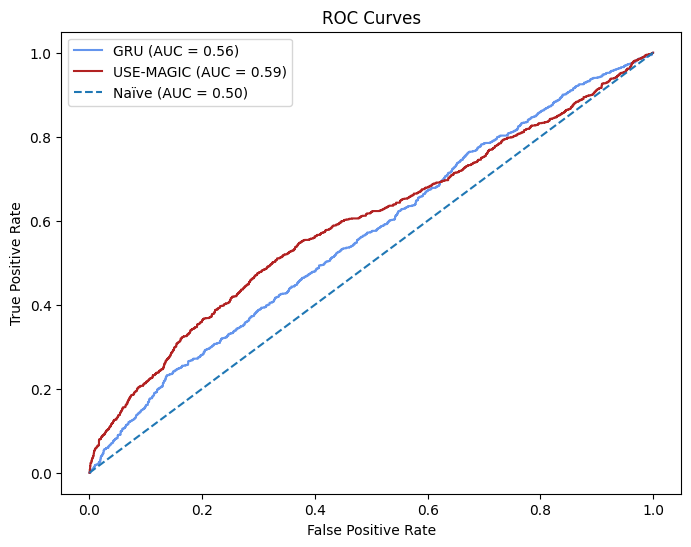

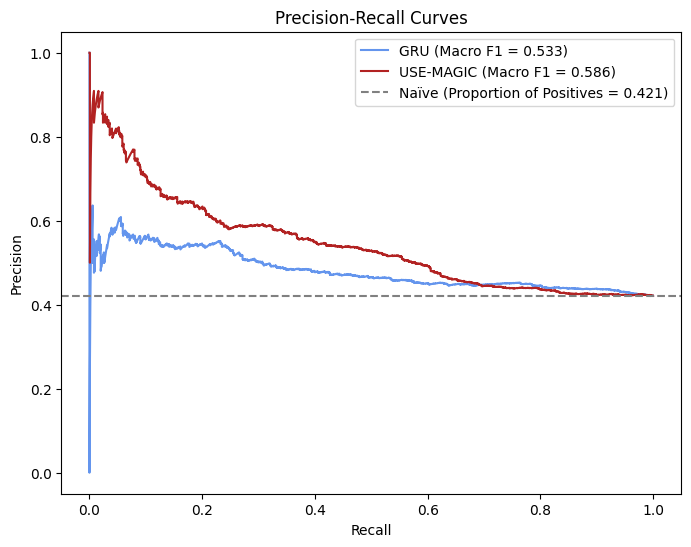

In [71]:
#Plot model and baseline ROC curve
# ROC curves
fpr, tpr, _ = roc_curve(y_test, y0_pred_proba)
fpr3, tpr3, _ = roc_curve(y_test, y1_pred_proba)


# AUC scores
auc_model = roc_auc_score(y_test, y0_pred_proba)
auc_model3 = roc_auc_score(y_test, y1_pred_proba)

# Precision-Recall curves
precision, recall, _ = precision_recall_curve(y_test, y0_pred_proba)
precision3, recall3, _ = precision_recall_curve(y_test, y1_pred_proba)


# Macro-average F1 scores
f1_model = f1_score(y_test, np.round(y0_pred_proba), average='macro')
f1_model3 = f1_score(y_test, np.round(y1_pred_proba), average='macro')


# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'GRU (AUC = {auc_model:.2f})', color = 'cornflowerblue')
plt.plot(fpr3, tpr3, label=f'USE-MAGIC (AUC = {auc_model3:.2f})', color = 'firebrick')
plt.plot([0, 1], [0, 1], label='Naïve (AUC = 0.50)', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Plot Precision-Recall curves
positive_proportion = np.sum(y_test) / len(y_test)
# Plot Precision-Recall curves
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'GRU (Macro F1 = {f1_model:.3f})', color = 'cornflowerblue')
plt.plot(recall3, precision3, label=f'USE-MAGIC (Macro F1 = {f1_model3:.3f})', color = 'firebrick')
plt.axhline(positive_proportion, color='gray', linestyle='--', label=f'Naïve (Proportion of Positives = {positive_proportion:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()



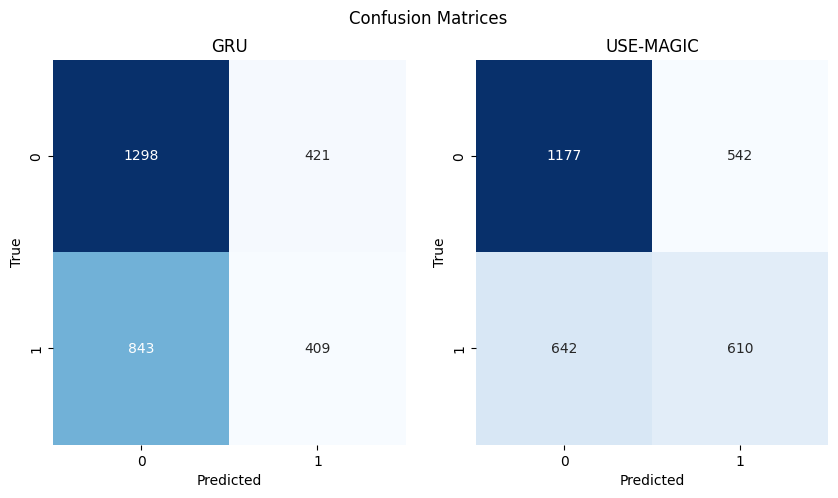

In [72]:
# Compute confusion matrices for each model
y0_pred = np.round(y0_pred_proba)
y3_pred = np.round(y1_pred_proba)

cm0 = confusion_matrix(y_test, y0_pred)
cm3 = confusion_matrix(y_test, y3_pred)

# Plot confusion matrices 

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Confusion Matrices")

sns.heatmap(cm0, annot=True, fmt="d", ax=axes[0], cmap="Blues", cbar=False)
axes[0].set_title("GRU")

sns.heatmap(cm3, annot=True, fmt="d", ax=axes[1], cmap="Blues", cbar=False)
axes[1].set_title("USE-MAGIC")

for ax in axes.flat:
    ax.set(xlabel='Predicted', ylabel='True')

plt.show()

